In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### MNIST 99.82%

Here we describe our experiment with the venerable MNIST dataset of hand-written digits.

* We reliably get a classification accuracy of 99.82 percent on the ten thousand test images, after training on the sixty-thousand training images.  This is with a committee of 35 neural net classifiers.  Single-net classification accuracy is usually in the mid 99.7 to 99.8 range.

* Each net trains in about three minutes on our GTX-1080ti GPU, with only ten presentations of the training set (ten epochs).

* Along with this notebook, we release the source code of our system, written in Python using PyTorch, so others can reproduce or use our results.

### Data

In [2]:
from mnist import *
trainset = mnist_trainset(heldout=0)
testset = mnist_testset()

Our training dataset includes on-the-fly augmentation.
Each time an image is retrieved, it is randomly cropped
to move it around a little, and also subjected to a small amount
of random rotation, and then a small amount of elastic distortion
is applied.

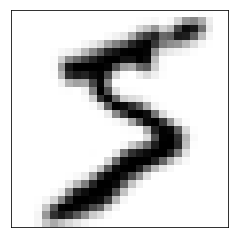

In [3]:
# Here we take the first image in the train dataset and display it.
# To see the effect of the augmentation, you can simply refresh this
# cell repeatedly with Ctrl-Enter.
image, label = trainset[0]
show_image(image)

In [4]:
# We set up to retrieve batches at a time.
batcher = Batcher(trainset, bs=144)

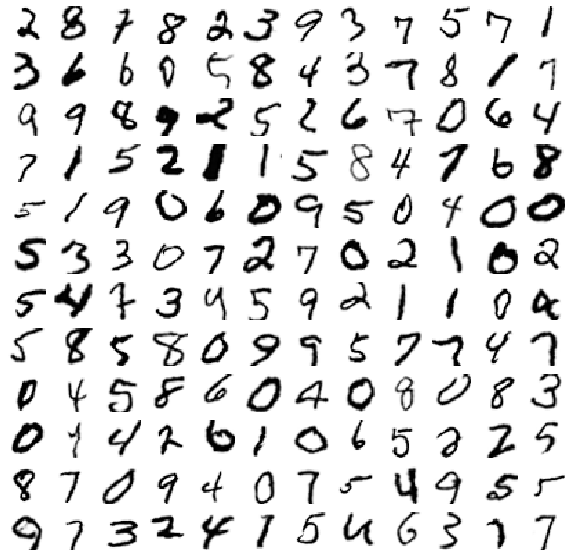

In [5]:
# Display a batch of (augmented) images.  You can refresh 
# this cell with Ctrl-Enter to see additional batches.
images, labels = next(batcher)
plot_images(images)

### Model

Below is the model we use for the MNIST classifier, expressed in PyTorch.

* It is a fairly conventional multilayer convolutional neural net 
with some Resnet-like elements.
* The Residual blocks are ordinary 3x3 convolutions with a shortcut connection going around.
* It makes heavy use of batchnorm, perhaps to a fault.
* It uses old-school maxpool instead of strided convolutions, but we haven't tried the latter.
* It has 7 convolutional layers, including the Residual blocks, which end with 512 4x4 activations.
* These are averaged into a vector of 512 activations, and then a single small dense layer converts those to ten logits output.

In [6]:
class Residual(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.bn = nn.BatchNorm2d(d)
        self.conv3x3 = nn.Conv2d(in_channels=d, out_channels=d,
                                 kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn(x)
        return x + F.relu(self.conv3x3(x))

def mnist_model():
    "Returns an initialized but untrained model for MNIST."
    return nn.Sequential(
               nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, padding=2),
               nn.ReLU(),

               Residual(128),
               nn.MaxPool2d(2),
               Residual(128),

               nn.BatchNorm2d(128),
               nn.Conv2d(128, 256, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2),
               Residual(256),

               nn.BatchNorm2d(256),
               nn.Conv2d(256, 512, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2, ceil_mode=True),
               Residual(512),

               nn.BatchNorm2d(512),
               nn.AvgPool2d(kernel_size=4),
               Flatten(),

               nn.Linear(512,10),
               # Softmax provided during training.
           )

### Training

In [7]:
# We will use the following  one-cycle learning
# schedule for all training in this notebook.  The learning rate
# starts at lr_start, goes to lr_middle at 30% of the training,
# then goes to lr_end.  We use cosine interpolation to smoothly
# go from one to the next.
# Similarly, momentum follows p_start, p_middle, and p_end.
# The learning schedule is plotted later in this notebook, and
# we explain what lr_eff is and why we calculate them as shown.
lr_eff = 0.001
p_max = 0.95
p_min = 0.60
params = {'epochs': 10, 'bs': 100,
          'lr_start': (1.0 - p_max) * lr_eff,
          'lr_middle': (1.0 - p_min) * lr_eff,
          'lr_end': (1.0 - p_min) * (lr_eff / 25),
          'p_start' : p_max,
          'p_middle' : p_min,
          'p_end' : p_min}

In [8]:
def train_one(trainset, testset):
    "Train one instance of our MNIST model."

    model = mnist_model()
    trainer = Trainer(model, trainset)
    one_cycle(trainer, **params)

    acc, lss = accuracy(Classifier(model), ds=testset, include_loss=True)
    print(f"test set: loss = {lss:.3g}, accuracy = {percent(acc)}")
    return model

In [9]:
m1 = train_one(trainset, testset)

test set: loss = 0.00787, accuracy = 99.76%


This net trained in about three minutes and the
single-net performance is typically near the top of the systems listed on Yann LeCun's
site (see References).

In [10]:
# Let's train four more.
m2 = train_one(trainset, testset)
m3 = train_one(trainset, testset)
m4 = train_one(trainset, testset)
m5 = train_one(trainset, testset)

test set: loss = 0.0075, accuracy = 99.79%


test set: loss = 0.00763, accuracy = 99.75%


test set: loss = 0.00787, accuracy = 99.72%


test set: loss = 0.008, accuracy = 99.74%


In [11]:
# Wrap each of the trained models into a Classifier object.
classifiers = [Classifier(m) for m in [m1, m2, m3, m4, m5]]
# And combine those classifiers into a committee classifier.
voter = VotingClassifier(classifiers)

# Let's see how it does!
acc = accuracy(voter, ds=testset)
print(f"Committee of {len(classifiers)} accuracy: {percent(acc)}")

Committee of 5 accuracy: 99.84%


For a committee of five, we typically see about 99.79 percent, which is among the best listed on Yann LeCun's site (circa 2012).

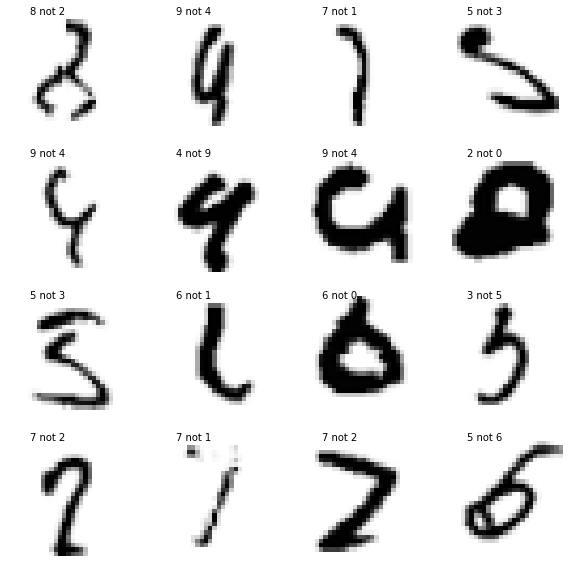

In [12]:
# Let's see the items in the test set that our committee-of-five got wrong.
show_mistakes(voter, testset)

For convenience, we wrote a simple Python script which trains a large population of models and writes them to disk, then chooses random committees from it, with a committee size we specify.

That way we can easily see how committees of different size perform.  It seems conventional to use a committee of 35, so that is what we use to justify our claim of 99.82 percent accuracy on the test set.

In [13]:
%run committee.py --population 250 --committee 5 --trials 4

Population of 250: training is complete.
1: Committee of 5 accuracy: 99.80%
2: Committee of 5 accuracy: 99.80%
3: Committee of 5 accuracy: 99.79%
4: Committee of 5 accuracy: 99.77%
mean: 99.79% (0.9979)


<Figure size 432x288 with 0 Axes>

In [14]:
%run committee.py --population 250 --committee 15 --trials 5

Population of 250: training is complete.
1: Committee of 15 accuracy: 99.84%
2: Committee of 15 accuracy: 99.81%
3: Committee of 15 accuracy: 99.82%
4: Committee of 15 accuracy: 99.82%
5: Committee of 15 accuracy: 99.80%
mean: 99.82% (0.99818)


In [15]:
%run committee.py --population 250 --committee 35 --trials 10

Population of 250: training is complete.
1: Committee of 35 accuracy: 99.82%
2: Committee of 35 accuracy: 99.83%
3: Committee of 35 accuracy: 99.83%
4: Committee of 35 accuracy: 99.79%
5: Committee of 35 accuracy: 99.83%
6: Committee of 35 accuracy: 99.84%
7: Committee of 35 accuracy: 99.82%
8: Committee of 35 accuracy: 99.82%
9: Committee of 35 accuracy: 99.82%
10: Committee of 35 accuracy: 99.82%
mean: 99.82% (0.99822)


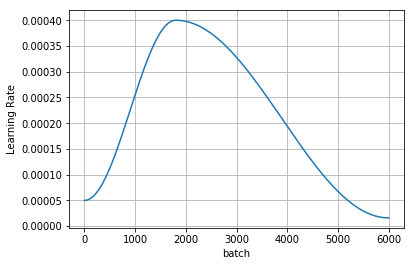

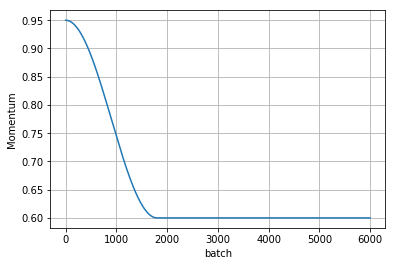

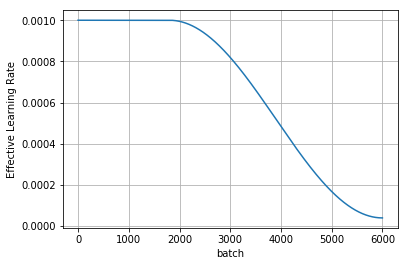

In [16]:
# When we train a net, one_cycle() returns an object which lets us plot
# information collected during training. We'll use that to plot the
# learning schedule specified above.

trainer = Trainer(mnist_model(), trainset)
recorder = one_cycle(trainer, **params)
recorder.plot_lr()
recorder.plot_mom()
recorder.plot_elr()

The Learning Rate and Momentum curves show the values used at each batch step.

In the third curve, the Effective Learning Rate is simply computed from learning rate, $L$ and momentum, $P$ as $L / (1 - P)$.  At no momentum, this reduces to the learning rate.  At $P=1$, it diverges.  Although the concept is not perfect, we find the notion of effective learning rate to be useful when we make changes to both the $L$ and $P$ schedule but would like to keep the combined learning rate approximately the same.

In the third curve, the effective learning rate traces out a conventional-looking learning schedule--starting high and constant, then tapering off (with cosine annealing here).

In the code, above, which sets the hyperparameters, we in fact chose the effective learning rate to be 0.001, and wanted a constant effective learning rate for the first part of the cycle, followed by a conventional tail.  With that specified, and the momentum specified, the actual learning rate is determined from those.

We tried several learning cycles, and this one worked as well as any of the others.

In the plots below, we do a learning rate sweep (like the one used in the fastai library) and plot the learning rate in terms of both Learning Rate and Effective Learning Rate.  You can see that on the latter curve, the Effective Learning Rate we chose, 0.001, falls on the "sweet spot" of the curve.  (The momentum was set at 0.95 because that is what it is initially in our schedule.)

stopping at step 383


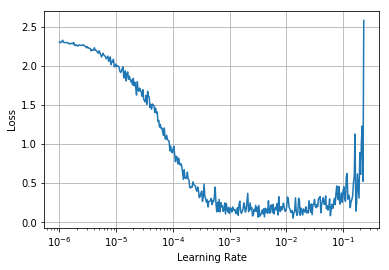

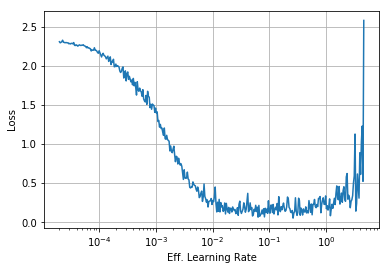

In [17]:
trainer = Trainer(mnist_model(), trainset)
lr_find(trainer, p=0.95, bs=100);

### Thoughts

We are surprised that it is possible to get to 99.82 percent accuracy on the test set with only ten epochs of training.  Training with 4 epochs is almost as good, and it is possible that other hyperparameters could make that work as well.

We find that the increasing-then-decreasing learning rate, with momentum in counterpoise, is important.

For regularization, we rely on batchnorm and, probably, the fact that we do not train for very long.  Adding dropout to the small dense layer at the end seemed to have little or no effect.  We do not use any weight decay, and in fact this model tolerates none.  Even small nonzero values of weight decay make the model do noticeably worse.  But surprisingly, the norms of the parameter layers are not large--not much bigger than the randomly initialized values (which are PyTorch defaults).  And the activations are not large either.  Nevertheless, weight decay, for some reason, kills this model.

The data augmentation made a significant difference, taking our single-net performance from the 99.60's to 99.70's range.  We suspect that this works primarily by keeping the network from overfitting to the one-hot labels and training images too quickly (as opposed to, for example, learning more robust representations).

Interestingly, the network never sees the unaugmented data during training.  Yet experiments indicate that it is just starting to "overfit" on this data that it has never seen at the end of training--it classifies the unaugmented training data (which it has never seen) better than the next epoch of augmented training data.

Consistent with this, at the end of our ten epochs of training, we have not yet reached perfect accuracy on the training set.  We are certainly doing "early stopping" by an indirect means, and this is part of why we think the data augmentation has more to do with "early stopping" than it has to do with robust representations.

Todd Doucet  
Pittsburgh, January 2019

### References

> Jeremy Howard's [**fast.ai site**](https://www.fast.ai)
and [**fastai library**](https://github.com/fastai/fastai)  
The code we wrote is all in native PyTorch, but many of the
ideas and some of the style is inspired by the new fastai 1.0
library.  We think the library is wonderful, and Jeremy's courses
are a treasure.  The only reason we didn't use fastai directly is that it was just too much fun to write what we needed.  Also, this was an exercise in learning PyTorch.

> Yann LeCun's [**MNIST site**](http://yann.lecun.com/exdb/mnist/)  
It looks like the results have not been updated since about 2012.  So we do not claim that our result is the best out there, only that we think we have a good and interesting result.

> [**A disciplined approach to neural network hyperparameters**](https://arxiv.org/pdf/1803.09820.pdf)  
Leslie N. Smith  
The idea of varying the learning rate and momentum in counterpoise was first described, as far as we can tell, by Leslie Smith.  It was adopted by the fastai library, and we did our own version of it.

> [**Regularization of neural networks using DropConnect**](https://cs.nyu.edu/~wanli/dropc/dropc.pdf)  
Li Wan, Matthew Zeiler, Sixin Zhang, Yann LeCun, and Rob Fergus  
This paper's focus is not on MNIST, but they get a better
result on MNIST than the best result on Yann LeCun's site.  (But not
as good as the result we get here, and they use many more epochs in
training.)